In [1]:
import pandas as pd
from datatools_bdh import _get_resource_path
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(_get_resource_path('report.mplstyle'))
def displaymd(mdstr):
    display(Markdown(mdstr))

In [2]:
data_path = "../data"
val_loss = pd.read_csv(f"{data_path}/val_loss_detail_pdepoch50.csv")
val_loss.set_index(['epoch','batch_id','index'])

# there are some irregular rows in this val loss .csv, we split them out below
total_rows = val_loss.isna().any(axis=1)
if any(total_rows):
    val_loss_totals = val_loss[total_rows]
    val_loss = val_loss[~total_rows]
if val_loss_totals.iloc[0,0][0] == '[':
    val_loss_totals.iloc[:,-3:] = val_loss_totals['epoch'].str[1:-1].str.split(expand=True)
    val_loss_totals.loc[:,'epoch'] = val_loss.loc[val_loss_totals.index-1, 'epoch']

In [3]:
train_loss = pd.read_csv(f"{data_path}/train_loss_detail_pdepoch50.csv")

In [4]:
import numpy as np
def col_to_int(col):
    return lambda x: pd.to_numeric(x[col]).astype(int)
train_loss = train_loss.assign(epoch=col_to_int('epoch'),
                  batch_id=col_to_int('batch_id'),
                  index=col_to_int('index'))
val_loss = val_loss.assign(epoch=col_to_int('epoch'),
                  batch_id=col_to_int('batch_id'),
                  index=col_to_int('index'))
num_index = train_loss['index'].unique().shape[0] # batch_size
train_loss['ex_id'] = train_loss['batch_id']*num_index+train_loss['index']
val_loss['ex_id'] = val_loss['batch_id']*num_index+val_loss['index']

In [5]:
color_cycle_plt = plt.rcParams['axes.prop_cycle'].by_key()['color']

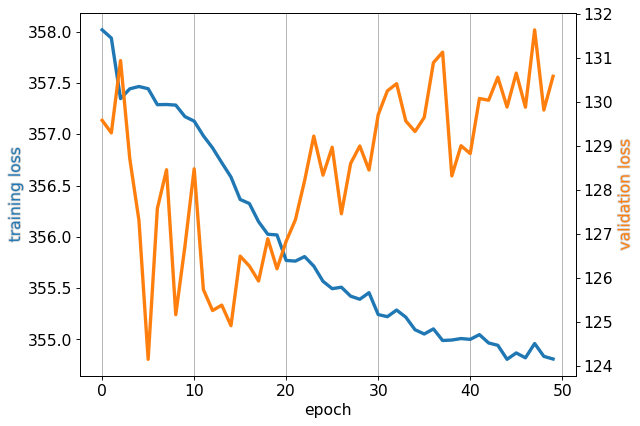

In [6]:
import matplotlib.patheffects as pe
peff = [pe.withStroke(linewidth=1.5, foreground="lightgray")]

#ax = plt.su(figsize=(16,12))
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
train_loss.groupby('epoch').mean().loc[:,"t1":].sum(axis=1).plot(ax=ax)
# twin object for two different y-axis on the sample plot
ax.set_ylabel("training loss",
               color=color_cycle_plt[0],
               fontsize=14, 
               path_effects=peff)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(gapminder_us.year, gapminder_us["gdpPercap"],color="blue",marker="o")
ax2.set_ylabel("validation loss",
               color=color_cycle_plt[1],
               fontsize=14, 
               path_effects=peff)
val_loss.groupby('epoch').mean().loc[:,"t1":].sum(axis=1).plot(c=color_cycle_plt[1], ax=ax2)
ax.xaxis.grid(True)
ax2.set_axisbelow(True)

# Distribution of loss term slope across training and validation examples
For each training or validation example, the three loss terms t1, t2, t3 are each fitted to a linear model w.r.t. training time given by the number of epochs.
A negative slope indicates that the respective loss term for an example improves (i.e. gets smaller with increasing epochs).

We are sorting the slopes across all examples to get an idea of their distribution around the average slope across all examples (average slope of total loss),
which is indicated by a gray horizontal line in each plot.


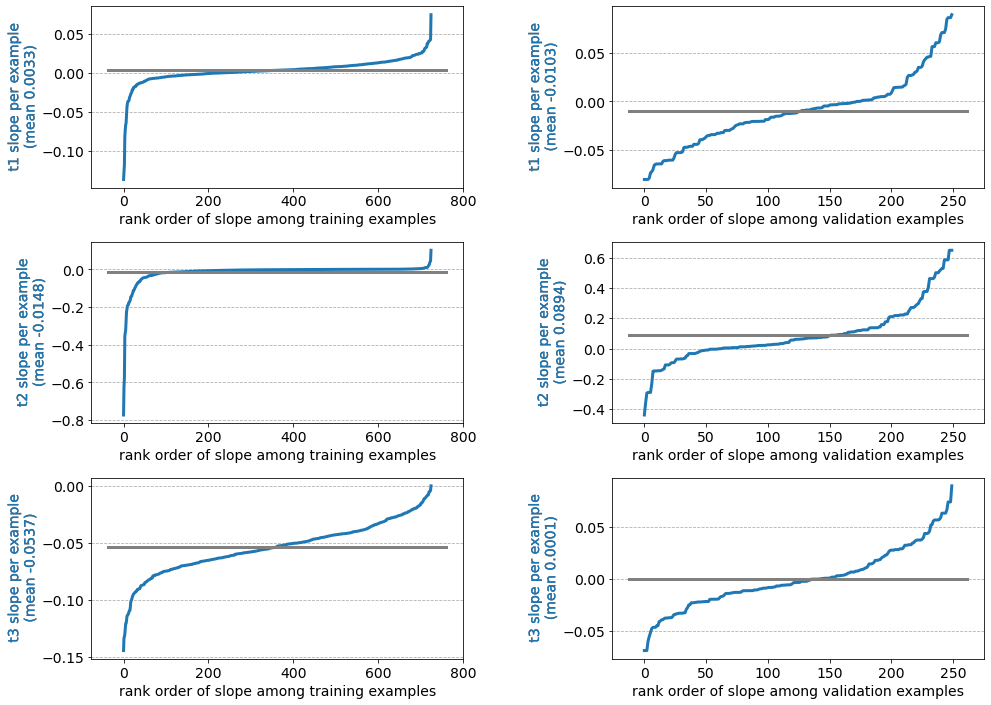

In [7]:
from scipy import stats

plt.rc('text', usetex=False)
peff = [pe.withStroke(linewidth=.2, foreground="black")]

def plot_target_field(target_field, sample_data, **kwargs):
    lmdf = (sample_data
            .groupby('ex_id')
            .apply(lambda gn: stats.linregress(gn['epoch'], gn[target_field]))
            .apply(pd.Series)
           )
    lmdf.columns = "slope intercept r_value p_value std_err".split()
    mean_slope = lmdf['slope'].mean()
    plt.plot(lmdf['slope'].sort_values().values, linewidth=3, **kwargs)
    plt.plot(plt.gca().get_xlim(),
             [mean_slope]*2,
             color='gray',
             **kwargs)
    plt.ylabel(f'{target_field} slope per example\n(mean {mean_slope:.4f})',
               color=color_cycle_plt[0],
               fontsize=14, 
               path_effects=peff)
    plt.xlabel('rank')
    plt.gca().yaxis.grid(True, linestyle='dashed')
    return lmdf

#plt.figure(figsize=(6,4))
fig, axs = plt.subplots(3,2, figsize=(16, 12))
displaymd("""# Distribution of loss term slope across training and validation examples
For each training or validation example, the three loss terms t1, t2, t3 are each fitted to a linear model w.r.t. training time given by the number of epochs.
A negative slope indicates that the respective loss term for an example improves (i.e. gets smaller with increasing epochs).

We are sorting the slopes across all examples to get an idea of their distribution around the average slope across all examples (average slope of total loss),
which is indicated by a gray horizontal line in each plot.
""")
plt.subplots_adjust(wspace=.4, hspace=.3)
vlmdfs = None
tlmdfs = None
for tid, term in enumerate(['t1', 't2', 't3']):
    #sample_data = choose_N_examples(val_loss, N=10, field='ex_id')
    ax=axs[tid][1] # right axis in row tid
    plt.sca(ax)
    vlmdf = plot_target_field(term, val_loss)
    vlmdf['term'] = term
    vlmdfs = pd.concat([vlmdfs, vlmdf])
    plt.xlabel('rank order of slope among validation examples')
    sample_data = (train_loss.groupby('ex_id')
                                  .sample(3)
                                  .reset_index(drop=False))
    ax=axs[tid][0] # left axis in row tid
    plt.sca(ax)
    tlmdf = plot_target_field(term, train_loss)
    tlmdf['term'] = term
    tlmdfs = pd.concat([tlmdfs, tlmdf])
    plt.xlabel('rank order of slope among training examples');


In [8]:
def add_ex_info(lmdfs, df):
    if 'batch_id' not in lmdfs:
        ex_ids = df[['batch_id','index','ex_id']].drop_duplicates()
        #display(ex_ids)
        lmdfs = lmdfs.join(ex_ids)#.sort_values(by='slope', ascending=False)
        return lmdfs.set_index(['batch_id','index']).sort_index()
    return lmdfs
vlmdfs = add_ex_info(vlmdfs, val_loss)
tlmdfs = add_ex_info(tlmdfs, train_loss)

#.plot(style='.', alpha=.5)
#sns.heatmap(data=vlmdfs, x='batch_id', y='index', c='slope')

In [9]:
def floor_factor(value, factor):
    return np.floor(value/factor)*factor

def ceil_factor(value, factor):
    return np.ceil(value/factor)*factor

def grid_ticks(ser, step=.05):
    return np.arange(floor_factor(ser.min(), step),
                     ceil_factor(ser.max(), step),
                     step)

do_show_scatterslopes = False
if do_show_scatterslopes:
    tlmdfs['slope'].plot(style='.', alpha=.1)
    # make a grid of .05 spaced ticks
    plt.gca().set_yticks(grid_ticks(tlmdfs['slope']))
    plt.grid('minor')

# Comparing loss slope distribution between training and validation

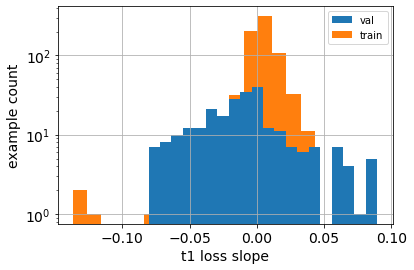

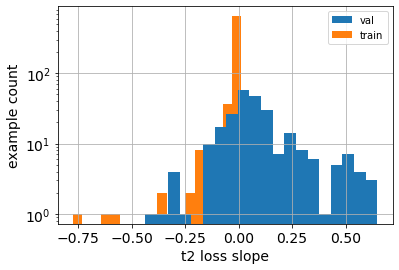

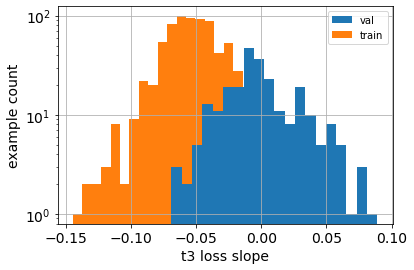

In [10]:
displaymd("# Comparing loss slope distribution between training and validation")
hist_ps = dict(bins=20, log=True)
for field in ['t1', 't2', 't3']:
    (vlmdfs[(vlmdfs['term']==field).values]
      .sort_index()['slope']
      .hist(**hist_ps)
    )
    (tlmdfs[(tlmdfs['term']==field).values]
      .sort_index()['slope']
      .hist(**hist_ps, zorder=0)
    )
    plt.yscale('log')
    plt.legend(['val', 'train'])
    plt.xlabel(f"{field} loss slope")
    plt.ylabel("example count");
    plt.show()
    #sns.heatmap(data=vlmdfs, x='batch_id', y='index', c='slope')

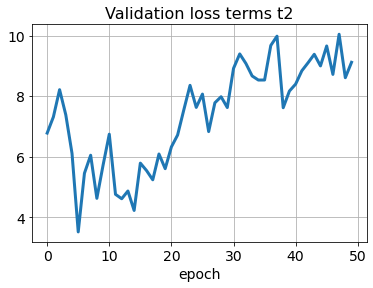

In [11]:
import matplotlib.pyplot as plt
target_term = "t2"
if False:
    trainval = "Training"
    dat = train_loss
else:
    trainval = "Validation"
    dat = val_loss
# taking the mean across: batch_id, index
(dat.groupby('epoch').mean().loc[:,target_term]
 #.sum(axis=1)
 .plot())
plt.title(f"{trainval} loss terms {target_term}")
plt.grid(True)

In [12]:
# target_field = 't3'
# sample_data.loc[sample_data.groupby('epoch').groups[0]]['ex_id'].unique()
# (
#         sample_data
#         .groupby('ex_id')
#         .apply(lambda gn: stats.linregress(gn['epoch'], gn[target_field]))
#         .apply(pd.Series)[0].median()#.T.values
#     )


In [13]:
#vlmdfs.sort_values('slope', ascending=False).index[:10]

# (val_loss
#  .set_index(['batch_id','index'])
# .join(vlmdfs.sort_values('slope', ascending=False).iloc[:10]))

#tlmdfs.sort_values('slope', ascending=False).iloc[:10]


# Loss change per example across epochs

## Validation performance across epochs

### Top 10 examples for t1

,,slope,term,ex_id
batch_id,index,,,
56,0,-0.080543,t1,224
51,1,-0.080543,t1,205
50,1,-0.080543,t1,201
52,1,-0.080543,t1,209
46,3,-0.079095,t1,187
16,0,-0.073528,t1,64
21,3,-0.072638,t1,87
34,1,-0.070337,t1,137
28,0,-0.065865,t1,112


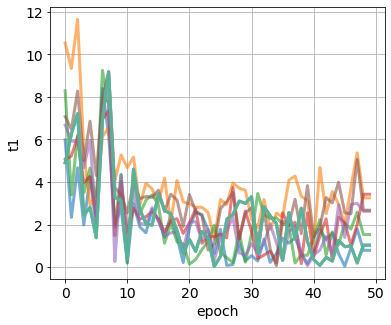

### Bottom 10 examples for t1

slope term  ex_id
batch_id index                      
58       3      0.068853   t1    235
         0      0.071097   t1    232
57       0      0.071097   t1    228
59       0      0.071097   t1    236
54       2      0.074620   t1    218
51       2      0.084835   t1    206
54       3      0.086462   t1    219
55       3      0.086462   t1    223
53       3      0.086462   t1    215
55       2      0.089521   t1    222

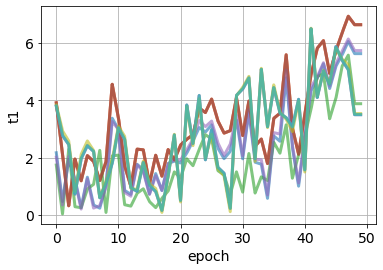

### Top 10 examples for t2

,,slope,term,ex_id
batch_id,index,,,
22,1,-0.437949,t2,89
27,2,-0.359666,t2,110
21,1,-0.293692,t2,85
27,3,-0.289164,t2,111
26,3,-0.289164,t2,107
25,3,-0.289164,t2,103
16,0,-0.232312,t2,64
15,0,-0.149833,t2,60
20,2,-0.147516,t2,82


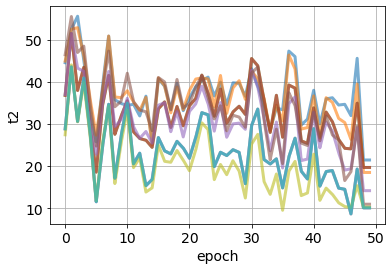

### Bottom 10 examples for t2

,,slope,term,ex_id
batch_id,index,,,
61,1,0.519555,t2,245
46,1,0.528292,t2,185
56,3,0.528368,t2,227
13,3,0.584744,t2,55
18,2,0.584744,t2,74
12,3,0.584744,t2,51
14,3,0.584744,t2,59
44,2,0.647906,t2,178
46,2,0.647906,t2,186


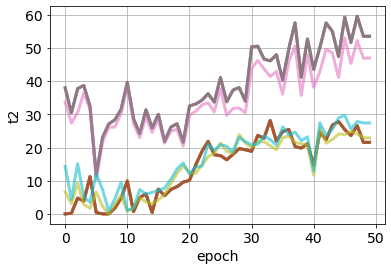

### Top 10 examples for t3

,,slope,term,ex_id
batch_id,index,,,
28,3,-0.068934,t3,115
30,3,-0.068934,t3,123
29,3,-0.068934,t3,119
23,3,-0.059841,t3,95
30,0,-0.055363,t3,120
26,2,-0.051623,t3,106
51,0,-0.047806,t3,204
8,0,-0.046644,t3,32
9,0,-0.046644,t3,36


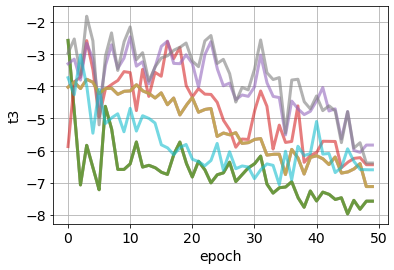

### Bottom 10 examples for t3

,,slope,term,ex_id
batch_id,index,,,
57,1,0.058525,t3,229
18,2,0.062850,t3,74
12,3,0.062850,t3,51
13,3,0.062850,t3,55
14,3,0.062850,t3,59
58,3,0.066014,t3,235
59,0,0.073595,t3,236
58,0,0.073595,t3,232
57,0,0.073595,t3,228


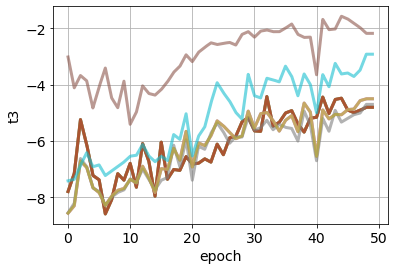

## Training performance across epochs

### Top 10 examples for t1

,,slope,term,ex_id
batch_id,index,,,
0,2,-0.136836,t1,2
31,2,-0.127892,t1,126
0,1,-0.118002,t1,1
131,2,-0.081759,t1,526
0,3,-0.073118,t1,3
2,3,-0.066814,t1,11
32,0,-0.064167,t1,128
1,3,-0.054569,t1,7
93,3,-0.044053,t1,375


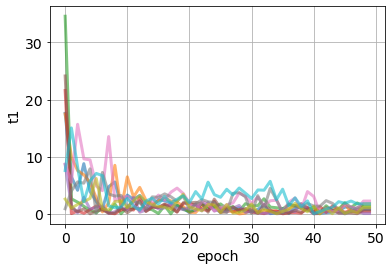

### Bottom 10 examples for t1

slope term  ex_id
batch_id index                      
134      3      0.037689   t1    539
77       2      0.037811   t1    310
76       3      0.038389   t1    307
108      0      0.039997   t1    432
106      0      0.040736   t1    424
76       2      0.041003   t1    306
         0      0.041574   t1    304
37       1      0.042004   t1    149
75       1      0.042666   t1    301
76       1      0.074739   t1    305

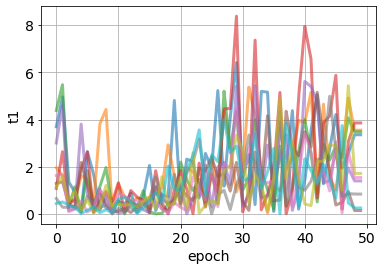

### Top 10 examples for t2

,,slope,term,ex_id
batch_id,index,,,
31,2,-0.773649,t2,126
100,1,-0.625736,t2,401
0,2,-0.575543,t2,2
131,2,-0.353687,t2,526
0,3,-0.337639,t2,3
68,3,-0.322646,t2,275
13,1,-0.274577,t2,53
50,3,-0.223842,t2,203
37,3,-0.213974,t2,151


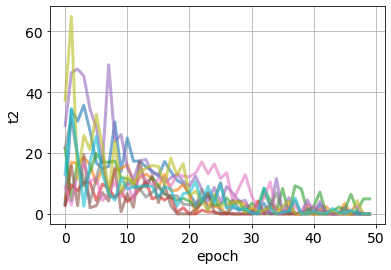

### Bottom 10 examples for t2

,,slope,term,ex_id
batch_id,index,,,
109,3,0.010202,t2,439
15,0,0.011130,t2,60
53,2,0.014830,t2,214
162,3,0.018245,t2,651
66,0,0.022391,t2,264
34,1,0.024511,t2,137
47,0,0.034469,t2,188
102,0,0.040819,t2,408
63,1,0.044164,t2,253


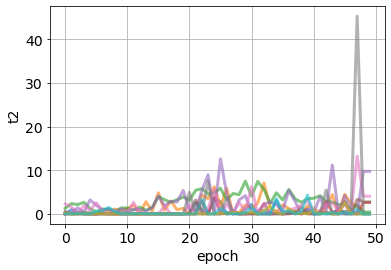

### Top 10 examples for t3

,,slope,term,ex_id
batch_id,index,,,
31,2,-0.144582,t3,126
75,2,-0.133310,t3,302
68,3,-0.132434,t3,275
0,2,-0.130082,t3,2
37,3,-0.124984,t3,151
13,0,-0.120919,t3,52
18,3,-0.120732,t3,75
32,0,-0.118236,t3,128
38,1,-0.114339,t3,153


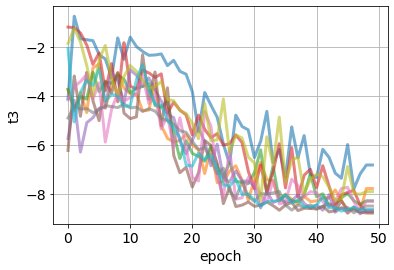

### Bottom 10 examples for t3

,,slope,term,ex_id
batch_id,index,,,
171,0,-0.008410,t3,684
12,1,-0.007874,t3,49
181,0,-0.007824,t3,724
31,1,-0.007723,t3,125
174,3,-0.005450,t3,699
178,2,-0.005331,t3,714
170,3,-0.004532,t3,683
165,2,-0.004512,t3,662
34,1,-0.003951,t3,137


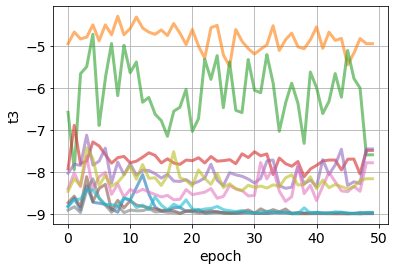

In [14]:
def plot_lines(gdf, groupvar='epoch', fields=['t1','t2'], 
               c=None, nsteps=100, 
               group_agg='mean', 
               cmap='turbo', decorate=True, 
               kind='scatter',
               **kwargs):
    if not groupvar is None:
        gdf = gdf.groupby(groupvar).mean()
    gdf = gdf.reindex(np.arange(0,gdf.index.max(),1/nsteps)).interpolate('linear')
    if c is None:
        c = gdf.index
    data_args = dict(data=gdf, x=fields[0], y=fields[1])
    if kind == 'scatter':
        plt.scatter(
            **data_args,
            c=c, s=3, cmap=cmap, 
            **kwargs)
    elif kind == 'line':
        sns.lineplot(
            data=gdf, x=groupvar, y=fields[0],
            #**data_args,
#            c=c, s=3, cmap=cmap, 
            **kwargs)
    else:
        sns.kdeplot(
            **data_args,
            **kwargs)
    if decorate:
        plt.xlabel(fields[0])
        plt.ylabel(fields[1])
        cbar = plt.colorbar()
        if not groupvar is None:
            cbar.set_label(groupvar)
            cbar.set_alpha(1)
            cbar.draw_all()
        plt.grid()


plt.figure(figsize=(6,5))

def plot_ex_loss_term(sel_ex, loss_df, fields=['t2','t3']):
    sel_ex_ids = sel_ex['ex_id']
    val_loss_sample = loss_df.set_index('ex_id').loc[sel_ex_ids]
    scatter_ps = dict(kind='scatter')
    line_ps = dict(kind='line', decorate=False, alpha=.6)
    kde_ps = dict(kind='kde', fill=True, cmap='mako', decorate=False)
    plot_ps = line_ps
    #k, gdf = 0, val_loss_sample
    display(sel_ex[['slope','term','ex_id']])
    for k, (gn, gdf) in enumerate(val_loss_sample.groupby('ex_id')):
        if not 'decorate' in plot_ps:
            add_arg = dict(decorate=(k==0))
        else:
            add_arg = {}
        plot_lines(gdf,
                   fields=fields,
                   **plot_ps,
                   **add_arg,
                  )
    plt.grid(True)

def show_top_bottom(field, lmdfs, loss_df, ntop=10):
    fields = [field, 't3']
    displaymd(f"### Top {ntop} examples for {field}")
    #ex_ids = val_loss[['batch_id','index','ex_id']].drop_duplicates()
    slmdfs = lmdfs.loc[lmdfs['term']==field].sort_values(by='slope', ascending=True)
    sel_ex = slmdfs.iloc[:ntop]
    plot_ex_loss_term(sel_ex, loss_df=loss_df, fields=fields)
    plt.show()

    displaymd(f"### Bottom {ntop} examples for {field}")
    sel_ex = slmdfs.iloc[-ntop:]
    plot_ex_loss_term(sel_ex, loss_df=loss_df, fields=fields)
    plt.show()

displaymd("# Loss change per example across epochs")
for mode, (lmdfs, loss_df) in {'Validation': (vlmdfs, val_loss),
                               'Training': (tlmdfs, train_loss)}.items():
    displaymd(f"## {mode} performance across epochs")
    show_top_bottom('t1', lmdfs, loss_df)
    show_top_bottom('t2', lmdfs, loss_df)
    show_top_bottom('t3', lmdfs, loss_df)